## Parte 3: Construyendo un Sistema de Recomendacion con Feedback Implicito

En este ejercicio, desarrollaremos un sistema de recomendacion con feedback implicito utilizando la libreria     [implicit](https://github.com/benfred/implicit).

**Pero, a que nos referimos con feedback implicito?**

En el primer ejercicio abordamos el filtro colaborativo el cual se basa en la suposicion de que `usuarios similares gustan de las mismas cosas/items`. La matriz usuario-item, o "matriz de utilidad" es la piedra angular del filtrado colaborativo. En la matriz de utilidad las filas representan a los usuarios y las columnas representan a los items.



Las celdas de la matriz se llenan a partir del grado de preferencia de un usuario a un item determinado y esto se representa en cualquiera de las dos formas:
1. **Feedback explicito:** feedback directo hacia un item (por ejemplo el rating de una pelicula como lo vimos en el [Ejercicio 1](https://experiencia21.tec.mx/courses/481176/assignments/15386625?module_item_id=28379086))

2. **Feedback implicito:** comportamiento indirecto hacia un item (por ejemplo el historial de compra, el historial de navegacion o historial de busquedas)

El feedback implicito hace suposiciones sobre las preferencias del usuario a partir de las acciones hacia dichos items. Si retomamos el ejemplo si miraste todos los episodios de un show y viste todas las temporadas en una semana, entonces existe la elevada posibilidad de que te guste ese show. Sin embargo, si empiezas a mirar una serie y te detienes a la mitad del primer episodio, entonces es probable que se pueda asumir que no te haya gustado ese show.

### Paso 1: Agregando las Librerias

Estos seran las librerias que utilizaremos:

- [numpy](https://numpy.org/)
- [pandas](https://pandas.pydata.org/)
- [implicit](https://github.com/benfred/implicit)
- scipy (en especifico la clase **csr_matrix**)

In [4]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
!pip install implicit
import implicit
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendación a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [2]:
import os
# Obtener la ruta del directorio actual
current_directory = os.getcwd()
print(current_directory)
# Cambiar el directorio de trabajo actual a 'new_directory'
#os.chdir('.//TC4034.10//RecommendationSystem//Data')
# Verificar el cambio imprimiendo el directorio de trabajo actual
os.chdir('../Data')
print(os.getcwd())

c:\git\TecMonterrrey\BigData\TC4034.10\RecommendationSystem\Notebooks
c:\git\TecMonterrrey\BigData\TC4034.10\RecommendationSystem\Data


In [5]:
movies = pd.read_csv("movies_metadata.csv",encoding="ISO-8859-1").drop_duplicates(keep='last',subset=['original_title']).dropna(subset=['vote_average'])
movies.head()

C:\Users\edwin\AppData\Local\Temp\ipykernel_10656\952175824.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv",encoding="ISO-8859-1").drop_duplicates(keep='last',subset=['original_title']).dropna(subset=['vote_average'])


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [5]:
#movies = pd.read_csv("/content/drive/MyDrive/MNA/Análisis de grandes volúmenes de datos TC4034.10/Proyecto/Avance 2 proyecto/movies_metadata.csv",encoding="ISO-8859-1").drop_duplicates(keep='last',subset=['original_title']).dropna(subset=['vote_average'])
movies.head()

<ipython-input-5-4c1751265fbe>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("/content/drive/MyDrive/MNA/Análisis de grandes volúmenes de datos TC4034.10/Proyecto/Avance 2 proyecto/movies_metadata.csv",encoding="ISO-8859-1").drop_duplicates(keep='last',subset=['original_title']).dropna(subset=['vote_average'])


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43369 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  43369 non-null  object 
 1   belongs_to_collection  4328 non-null   object 
 2   budget                 43369 non-null  object 
 3   genres                 43369 non-null  object 
 4   homepage               7512 non-null   object 
 5   id                     43369 non-null  object 
 6   imdb_id                43353 non-null  object 
 7   original_language      43358 non-null  object 
 8   original_title         43369 non-null  object 
 9   overview               42426 non-null  object 
 10  popularity             43369 non-null  object 
 11  poster_path            42991 non-null  object 
 12  production_companies   43369 non-null  object 
 13  production_countries   43369 non-null  object 
 14  release_date           43285 non-null  object 
 15  revenue

En este ejercicio, definiremos el rating de las peliculas como el número de veces que un usuario las ha mirado. Por ejemplo, si Jimena (una usuaria en nuestro dataset) le dio a la pelicula de`Batman` un rating de 1 y a `Jurassic Park` un rating de 5, podemos asumir que ha mirado la película de Batman una vez y la de Jurassic Park un total de 5 veces.

### Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de limpiar los datos partiendo de las dos siguientes consideraciones:

1. Los géneros de las películas están expresados en un formato de key-value pair. Debemos manipular este string en una lista que nos facilitará el análisis de los datos.
2. La columna release_date contiene la fecha exacta cuando fue estrenada la película.

#### Transformando los Géneros de un json a una lista



In [7]:
#Funcion para convertir el diccionario en lista
def cast_genres(genresStr):
    genresStr = genresStr.replace("'", '"')
    genres_ls = json.loads(genresStr)
    return [genre['name'] for genre in genres_ls]

In [8]:
movies['genres'] = movies['genres'].apply(lambda genresStr: [genre['name'] for genre in json.loads(genresStr.replace("'", '"'))])

In [9]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


#### Calculemos cuantos géneros de películas contiene el dataset?

Al utilizar la función de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada género en el dataset.

In [10]:
contador_generos = Counter(g for genres in movies['genres'] for g in genres)
print(f"Existen {len(contador_generos)} tipos de generos.")
contador_generos

Existen 20 tipos de generos.


Counter({'Animation': 1879,
         'Comedy': 12725,
         'Family': 2590,
         'Adventure': 3265,
         'Fantasy': 2120,
         'Romance': 6317,
         'Drama': 19112,
         'Action': 6217,
         'Thriller': 7050,
         'Horror': 4358,
         'History': 1326,
         'Crime': 4044,
         'Science Fiction': 2869,
         'Mystery': 2278,
         'Music': 1526,
         'Documentary': 3879,
         'War': 1262,
         'Foreign': 1575,
         'TV Movie': 728,
         'Western': 1000})

Existen 29 diferentes etiquetas para los géneros asignados a las películas de este dataset.


In [11]:
movies = movies[movies['genres']!='(no genres listed)']

del contador_generos['(no genres listed)']

#### Cuáles son los géneros de películas más comúnes?

Utilizaremos el metodo más común de `Counter` que es `most_common()` para obtener el listado de géneros con asociados a la mayor cantidad de películas.

In [12]:
print("Top 10 de generos de peliculas: \n", contador_generos.most_common(10))

Top 10 de generos de peliculas: 
 [('Drama', 19112), ('Comedy', 12725), ('Thriller', 7050), ('Romance', 6317), ('Action', 6217), ('Horror', 4358), ('Crime', 4044), ('Documentary', 3879), ('Adventure', 3265), ('Science Fiction', 2869)]


En el Top 10 de generos encontramos: `Drama`, `Comedia`, `Thriller`, `Romance`,`Accion`, `Terror`, `Crimen`, `Documentales`, `Aventura`, y `Ciencia Ficcion`.

Utilizemos barplot para visualizar esta informacion.

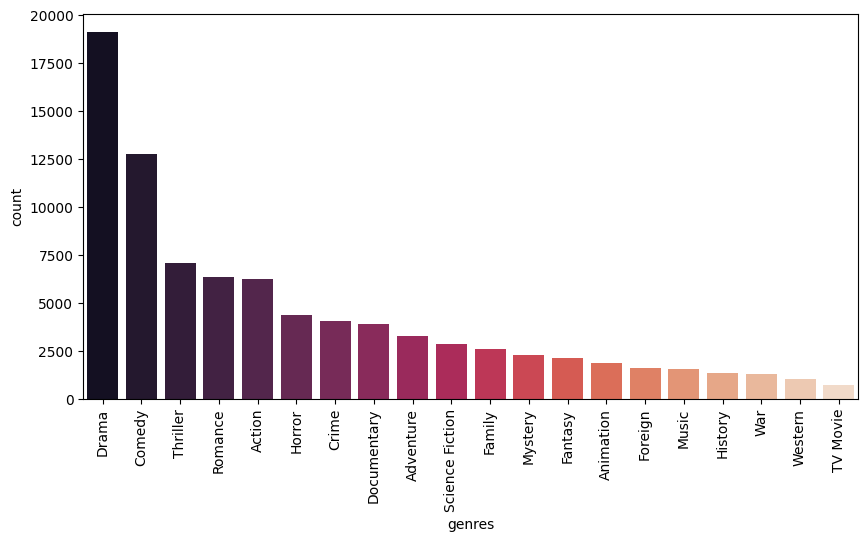

In [13]:
genres_counts_df = pd.DataFrame([contador_generos]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

La gráfica nos confirma lo que descubrimos anteriormente, `Drama` y `Comedia` son los géneros más populares mientras que los `War`, `Western`, and `TV Movie` son los menos populares.

### Paso 3: Transformando los datos

Tal y como lo hicimos en el [Ejercicio 1](https://experiencia21.tec.mx/courses/481176/assignments/15386625?module_item_id=28379086), necesitamos transformar el dataframe de `ratings` a una matriz usuario-item donde las filas representan a los usuarios y las columnas representan a las peliculas. Las celdas en esta matriz contendran el feedback implicito que en este caso es el numero de veces que un usuario ha visto una pelicula.

La funcion  `create_X()` crea una matriz de dispersion **X** con 4 diccionarios de mapeo:

- **user_mapper:** mapea user id al user index
- **movie_mapper:** mapea movie id al movie index
- **user_inv_mapper:** mapea user index al user id
- **movie_inv_mapper:** mapea movie index al movie id

Necesitamos estos diccionario por que hay que mapear las filas y columnas con la matriz de utilidad que les corresponde al user ID con su movie ID respectivamente.

Esta matriz dispersa **usuario-item** es una matriz que se obtiene al `usar scipy.sparse.csr_matrix`que almacena los datos de una manera dispersa.

In [14]:
def create_X(df: pd.DataFrame):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = movies.index.nunique()
    M = movies['id'].nunique()

    user_mapper = dict(zip(np.unique(movies.index), list(range(N))))
    movie_mapper = dict(zip(np.unique(movies['id']), list(range(M))))

    user_inv_mapper = dict(zip(list(range(N)), np.unique(movies.index)))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(movies['id'])))

    user_index = [user_mapper[i] for i in movies.index]
    movie_index = [movie_mapper[i] for i in movies['id']]

    X = csr_matrix((movies["vote_average"], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [15]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(movies)

### Creando los Mapeos de los titulos de las peliculas

Necesitamos traducir el titulo de una pelicula a partir de su indice en la matriz usuario-item y vice versa. Vamos a crear dos funciones que nos ayuden con esta traduccion.

- `get_movie_index()` - convierte el titulo de una pelicula a su indice. Hace uso de la funcion de comparacion de strings que se le pasan a [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy)
 para obtener el titulo de una pelicula que se le pase. Esto significa que no necesitamos saber la forma de escribir o el formato de una pelicula para obtener su indice.

- `get_movie_title()` - convierte el indice de una pelicula a su titulo.

In [16]:
!pip install fuzzywuzzy
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['original_title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

movie_title_mapper = dict(zip(movies['original_title'], movies['id']))
movie_title_inv_mapper = dict(zip(movies['id'], movies['original_title']))

def get_movie_index(title):
    fuzzy_title = movie_finder(title)
    movie_id = movie_title_mapper[fuzzy_title]
    movie_idx = movie_mapper[movie_id]
    return movie_idx

def get_movie_title(movie_idx):
    movie_id = movie_inv_mapper[movie_idx]
    title = movie_title_inv_mapper[movie_id]
    return title

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Vamos a probar esta funcion para obtener el indice de Toy Story

In [17]:
get_movie_index('The god father')

31678

In [18]:
get_movie_title(31678)

'The Good Father'

### Paso 4: Construyendo el modelo de modelo de Recomendacion de Feedback Implicito

Una vez que hemos transformado nuestros datos ahora si podemos empezar a construir nuestro modelo de recomendacion.


La libreria [implicit](https://github.com/benfred/implicit) esta basada en un factorizacion de matrices (tomado del algebra lineal). Esto nos permite hallar caracteristicas
latentes que se esconden en las interacciones entre los usuarios y las peliculas. Estas caracteristicas latentes nos brindan una representacion mas compacta de los gustos
de los usuarios y la descripcion de un item. La factorizacion matricial es particularmente util para datos muy dispersos y puede mejorar la calidad de las recomendaciones
obtenidas. El algoritmo opera al factorizar la matris usuario-item en dos matrices:

- matriz usuario-factorers  (n_users, k)
- matriz item-factorers     (k, n_items)

Reduciremos las dimensiones de nuestra matriz original a nuestras dimensiones particulares. No es posible interpretar cada caracteristica latente $k$. Sin embargo,
podemos suponer que una caracteristica latente puede representar a los usuarios que gusten de comedia romantica de los 90s, mientras que otra caracteristica lantente
puede representar a peliculas independientes extranjeras.


$$X_{mn} \approx P_{mk} \times Q_{nk}^T = \hat{X}$$



En el caso de una factorizacion matricial tradicional como [SVD](https://www.freecodecamp.org/news/singular-value-decomposition-vs-matrix-factorization-in-recommender-systems-b1e99bc73599/) lo que hariamos seria intentar resolver la factorizacion de una sola vez, sin embargo esto resultaria muy costoso computacionalmente. Otra forma de atacar este problem es utilizando una tecnica denominada
[Minimos Cuadrados Alternos, Alternating Least Squares (ALS)](https://sophwats.github.io/2018-04-05-gentle-als.html). Ocupando ALS, podemos resolver una matriz de factores a la vez:

- Paso 1: Fijamos la matriz de factores de usuario (user-factor) y resolvemos la matriz de factores de elementos (item-factor)
- Paso 2: Fijamos la matriz de factores de elementos (item-factor) y resolvemos la matriz de factores de usuario (user-factor)

Al alternar los pasos 1 y 2 hasta que el producto punto de la matriz de factores de elementos (item-factor) y la matriz de factores de usuarios (user-item) es aproximadamente igual a la matrix original X (user-item). Este procedimiento es comptacionalmente menos costoso y puede ser parelelizado.

La libreria `implicit` implementa una factorizacion matricial utilizando ALS (puedes consultar los detalles [aqui](https://implicit.readthedocs.io/en/latest/als.html))

In [19]:
model = implicit.als.AlternatingLeastSquares(factors=50)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Este modelo viene con algunos hyperparametros que deben ser ajustados para generar resultados optimos:

- los factores ($k$): numero de factores latentes,
- regularizacion ($\lambda$): evita que el modelo caiga en overfitting durante el entrenamiento

Para este ejercicio definiremos $k = 50$ y $\lambda = 0.01$ como los valores a utilizar.

El siguiente paso ahora es ajustar nuestro modelo a la matriz user-item.

In [20]:
model.fit(X.T.tocsr())

  0%|          | 0/15 [00:00<?, ?it/s]

Ahora pongamos a prueba las recomendaciones de nuestro modelo. Podemos utilizar el metodo `similar_items()` que nos muestra las peliculas mas relevantes dada una pelicula en especifico. De igual forma, podemos utilizar la funcion `get_movie_index()` para obtener el indice de la pelicula si es que es una pelicula que nos interesa a partir de las recomendaciones obtenidas.

In [21]:
movie_of_interest = 'forrest gump'

movie_index = get_movie_index(movie_of_interest)
related = model.similar_items(movie_index)
related

(array([ 4731,  6456, 40630,  7515,  2575, 27685, 26004, 43143, 38913,
        13598], dtype=int32),
 array([1.        , 0.6857444 , 0.6774148 , 0.65312237, 0.65311867,
        0.6507702 , 0.6494699 , 0.64723766, 0.640231  , 0.63697094],
       dtype=float32))

Lo que obtenemos de `similar_items()` no es facil de leer por lo que necesitamos de la funcion `get_movie_title()` para interpretar los resultados.

In [22]:
print(f"Por que miraste la pelicula de {movie_finder(movie_of_interest)} te pueden interesar las siguientes peliculas:")
for t, r in zip(related[0], related[1]):

    recommended_title = get_movie_title(t)
    if recommended_title != movie_finder(movie_of_interest):
        print(recommended_title)

Por que miraste la pelicula de Forrest Gump te pueden interesar las siguientes peliculas:
ÐÑÐ´Ñ ÐÐ°Ð½Ñ
A Christmas Story
Taxandria
The Big Lebowski
Sometimes a Great Notion
Hooligan Sparrow
9
That's Entertainment! III
The Epic of Everest


Al usar el rating de los usuarios como feedback implicito, los resultados se ven bien. Intenta cambiando la variable `movie_of_interest`.


### Paso 5: Generando las recomendaciones del usuario

Una caracteristica interesante de `implicit` es que puedes obtener recomendaciones personalizadas para un usuario determinado. Intentemos ver los resultados con un usuario especifico de nuestro dataset.

In [40]:
user_id = 90

In [41]:
user_ratings = movies[movies.index==user_id].merge(movies[['id', 'original_title']])
user_ratings = user_ratings.sort_values('vote_average', ascending=False)
print(f"El numero de peliculas rankeadas por el usuario {movies.index} es de: {user_ratings['id'].nunique()}")

El numero de peliculas rankeadas por el usuario Index([    0,     1,     2,     3,     4,     7,     8,     9,    10,    11,
       ...
       45455, 45456, 45457, 45458, 45459, 45460, 45462, 45463, 45464, 45465],
      dtype='int64', length=43285) es de: 1


In [42]:
user_ratings = movies[movies.index==user_id].merge(movies[['id', 'original_title']])
user_ratings = user_ratings.sort_values('vote_average', ascending=False)
top_5 = user_ratings.head()
top_5

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,History,Crime,Science Fiction,Mystery,Music,Documentary,War,Foreign,TV Movie,Western
0,False,NaN,47000000,"[Drama, Horror, Thriller, Romance]",NaN,9095,tt0117002,en,Mary Reilly,A housemaid falls in love with Dr. Jekyll and ...,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X_t = X.T.tocsr()
user_idx = user_mapper[user_id]
recommendations = model.recommend(user_idx, X_t[user_idx])
recommendations

(array([25978,  5054, 15272, 13411, 16931, 41003, 20025, 19181, 28033,
          962], dtype=int32),
 array([1.70376334e-05, 1.62156575e-05, 1.61703265e-05, 1.50339310e-05,
        1.47455776e-05, 1.46195325e-05, 1.43168072e-05, 1.39014501e-05,
        1.36753652e-05, 1.30540593e-05], dtype=float32))

In [44]:
for t, r in zip(recommendations[0], recommendations[1]):
    recommended_title = get_movie_title(t)
    print(recommended_title)

ÐÐµÐ¼Ð¸Ð´Ð¾Ð²Ñ
Cowboy del Amor
Fearless Fagan
Moving the Mountain
Criminal Justice
In Search of Ancient Astronauts
Running Wild
ì¢ì ì¹êµ¬ë¤
American Hostage
Eien no hito
